In [1]:
import numpy as np

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.xception import preprocess_input

In [5]:
import os

os.getcwd()

'D:\\github_repos\\mlzoomcamp\\MLZoomcamp_2022\\09_Serverless'

In [6]:
model = keras.models.load_model('clothing-model.h5')

In [7]:
img = load_img('pants.jpg', target_size=(299, 299))

x = np.array(img)
X = np.array([x])

X = preprocess_input(X)

In [8]:
preds = model.predict(X)

1/1 [==============================] - 9s 9s/step


In [9]:
preds

array([[-1.8798646, -4.7563095, -2.3595319, -1.0892638,  9.903784 ,
        -2.8261778, -3.64831  ,  3.2411537, -2.6120965, -4.852035 ]],
      dtype=float32)

In [11]:
classes = [
    'dress',
    'hat',
    'longsleeve',
    'outwear',
    'pants',
    'shirt',
    'shoes',
    'shorts',
    'skirt',
    't-shirt'
]

dict(zip(classes, preds[0]))

{'dress': -1.8798646,
 'hat': -4.7563095,
 'longsleeve': -2.3595319,
 'outwear': -1.0892638,
 'pants': 9.903784,
 'shirt': -2.8261778,
 'shoes': -3.64831,
 'shorts': 3.2411537,
 'skirt': -2.6120965,
 't-shirt': -4.852035}

### Convert Keras to TF-Lite

This demonstrates a few basic practices from this page: 

    https://www.tensorflow.org/lite/guide/python
    https://www.tensorflow.org/lite/models/convert/convert_models

In [12]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

tflite_model = converter.convert()

### Generate a tf-lite file storing model
with open('clothing-model.tflite', 'wb') as f_out:
    f_out.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\rizdi\AppData\Local\Temp\tmplymxwtfv\assets


INFO:tensorflow:Assets written to: C:\Users\rizdi\AppData\Local\Temp\tmplymxwtfv\assets


In [13]:
import tensorflow.lite as tflite

In [14]:
interpreter = tflite.Interpreter(model_path='clothing-model.tflite')
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]['index']
output_index = interpreter.get_output_details()[0]['index']

In [15]:
interpreter.set_tensor(input_index, X)
interpreter.invoke()
preds = interpreter.get_tensor(output_index)

In [16]:
classes = [
    'dress',
    'hat',
    'longsleeve',
    'outwear',
    'pants',
    'shirt',
    'shoes',
    'shorts',
    'skirt',
    't-shirt'
]

dict(zip(classes, preds[0]))

{'dress': -1.8798653,
 'hat': -4.7563086,
 'longsleeve': -2.3595326,
 'outwear': -1.0892627,
 'pants': 9.903783,
 'shirt': -2.8261797,
 'shoes': -3.648309,
 'shorts': 3.2411575,
 'skirt': -2.6120954,
 't-shirt': -4.8520327}

### Removing TF dependency

In [17]:
from PIL import Image

In [18]:
with Image.open('pants.jpg') as img:
    img = img.resize((299, 299), Image.NEAREST)

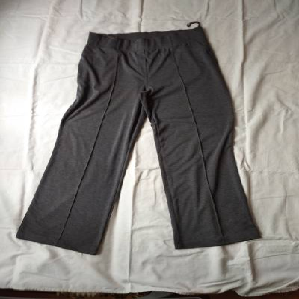

In [42]:
img

At this point, we will have to do some research on preprocessing. Since we want to replicate what had been done using Xception, what constructed in function `preprocess_input` is observed from this page: https://github.com/keras-team/keras/blob/master/keras/applications/xception.py. We see that this function returns as shown below:

```
@keras_export("keras.applications.xception.preprocess_input")
def preprocess_input(x, data_format=None):
    return imagenet_utils.preprocess_input(
        x, data_format=data_format, mode="tf"
    )
```

Go to this page: https://github.com/keras-team/keras/blob/2e88fa83600ac690dc38fb1d9b1ebf329e3da373/keras/applications/imagenet_utils.py and search which preprocess function that meet the mode criteria (`tf`).


In [19]:
def preprocess_input(x):
    x /= 127.5
    x -= 1.
    return x

In [20]:
x = np.array(img, dtype='float32')
X = np.array([x])

X = preprocess_input(X)

In [21]:
interpreter.set_tensor(input_index, X)
interpreter.invoke()
preds = interpreter.get_tensor(output_index)

In [22]:
classes = [
    'dress',
    'hat',
    'longsleeve',
    'outwear',
    'pants',
    'shirt',
    'shoes',
    'shorts',
    'skirt',
    't-shirt'
]

dict(zip(classes, preds[0]))

{'dress': -1.8798653,
 'hat': -4.7563086,
 'longsleeve': -2.3595326,
 'outwear': -1.0892627,
 'pants': 9.903783,
 'shirt': -2.8261797,
 'shoes': -3.648309,
 'shorts': 3.2411575,
 'skirt': -2.6120954,
 't-shirt': -4.8520327}

### Simpler way of doing it

This we apply a custom program made by Alexey Grigorev: 
https://github.com/alexeygrigorev/keras-image-helper

In [34]:
# import tflite_runtime.interpreter as tflite
from keras_image_helper import create_preprocessor

In [ ]:
!pip install --extra-index-url https://google-coral.github.io/py-repo/ tflite_runtime

In [32]:
interpreter = tflite.Interpreter(model_path='clothing-model.tflite')
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]['index']
output_index = interpreter.get_output_details()[0]['index']

In [39]:
interpreter.get_input_details()

[{'name': 'serving_default_input_8:0',
  'index': 0,
  'shape': array([  1, 299, 299,   3]),
  'shape_signature': array([ -1, 299, 299,   3]),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [40]:
interpreter.get_output_details()

[{'name': 'StatefulPartitionedCall:0',
  'index': 229,
  'shape': array([ 1, 10]),
  'shape_signature': array([-1, 10]),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [35]:
preprocessor = create_preprocessor('xception', target_size=(299, 299))

url = 'http://bit.ly/mlbookcamp-pants'
X = preprocessor.from_url(url)

In [36]:
interpreter.set_tensor(input_index, X)
interpreter.invoke()
preds = interpreter.get_tensor(output_index)

In [41]:
preds

array([[-1.8798653, -4.7563086, -2.3595326, -1.0892627,  9.903783 ,
        -2.8261797, -3.648309 ,  3.2411575, -2.6120954, -4.8520327]],
      dtype=float32)

In [37]:
classes = [
    'dress',
    'hat',
    'longsleeve',
    'outwear',
    'pants',
    'shirt',
    'shoes',
    'shorts',
    'skirt',
    't-shirt'
]

dict(zip(classes, preds[0]))

{'dress': -1.8798653,
 'hat': -4.7563086,
 'longsleeve': -2.3595326,
 'outwear': -1.0892627,
 'pants': 9.903783,
 'shirt': -2.8261797,
 'shoes': -3.648309,
 'shorts': 3.2411575,
 'skirt': -2.6120954,
 't-shirt': -4.8520327}

### Other applications: EfficientNet

In [45]:
import os

### Moving up one directory to `MLZoomcamp_2022'
os.chdir(os.path.dirname(os.getcwd()))

In [46]:
os.getcwd()

'D:\\github_repos\\mlzoomcamp\\MLZoomcamp_2022'

In [47]:
modelLoad_eff_net = keras.models.load_model(os.path.join(os.getcwd(), "08_Deep_learning/model_efficient_net.h5"))

In [53]:
from tensorflow.keras.utils import image_dataset_from_directory
from pathlib import Path

new_base_dir = Path("BirdImages")
source_dir = Path(os.path.join(os.getcwd(), "08_Deep_learning", new_base_dir))
IMAGE_SIZE = (260, 260)

test_dataset = image_dataset_from_directory(
    source_dir / "test",
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=32)

Found 151 files belonging to 3 classes.


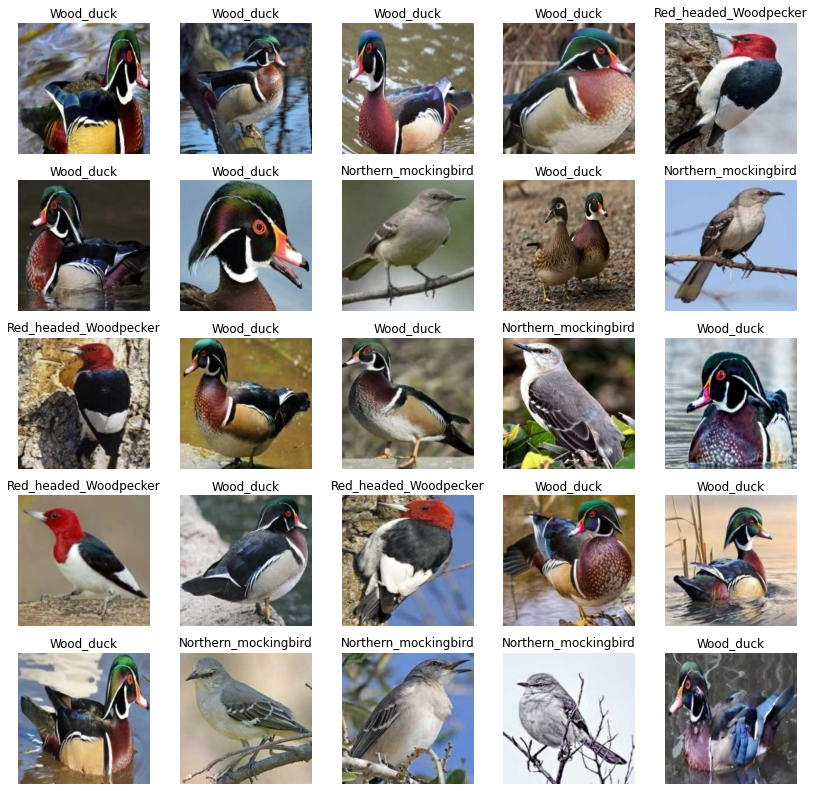

In [55]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(5, 5, sharex=True, sharey=True, figsize=(14,14))
class_names = test_dataset.class_names
for images, labels in test_dataset.take(1):
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [56]:
y_true = np.concatenate([y for x, y in test_dataset], axis=0)

pred = modelLoad_eff_net.predict(test_dataset)

5/5 [==============================] - 8s 393ms/step


In [62]:
print(y_true.shape)
print(pred.shape)

(151,)
(151, 3)


In [67]:
y_true[:3]

array([2, 0, 2])

In [65]:
pred[:3]

array([[0.1575345 , 0.70804596, 0.13441956],
       [0.10560591, 0.07835688, 0.81603724],
       [0.1373982 , 0.09120359, 0.7713982 ]], dtype=float32)

In [64]:
from sklearn.metrics import confusion_matrix

predictions = np.argmax(pred, axis=1)
confusion_matrix(y_true, predictions)

array([[13,  9, 23],
       [12,  9, 15],
       [20, 18, 32]], dtype=int64)

In [66]:
predictions[:3]

array([1, 2, 2], dtype=int64)

In [68]:
del converter, tflite_model

In [69]:
### Convert to TF-lite

converter = tf.lite.TFLiteConverter.from_keras_model(modelLoad_eff_net)

tflite_model = converter.convert()

### Generate a tf-lite file storing model
with open('duck-model.tflite', 'wb') as f_out:
    f_out.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\rizdi\AppData\Local\Temp\tmp2pognai7\assets


INFO:tensorflow:Assets written to: C:\Users\rizdi\AppData\Local\Temp\tmp2pognai7\assets


In [70]:
interpreter = tflite.Interpreter(model_path='duck-model.tflite')
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]['index']
output_index = interpreter.get_output_details()[0]['index']

In [71]:
interpreter.get_input_details()

[{'name': 'serving_default_input_23:0',
  'index': 0,
  'shape': array([  1, 260, 260,   3]),
  'shape_signature': array([ -1, 260, 260,   3]),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [72]:
interpreter.get_output_details()

[{'name': 'StatefulPartitionedCall:0',
  'index': 694,
  'shape': array([1, 3]),
  'shape_signature': array([-1,  3]),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [75]:
os.getcwd()

'D:\\github_repos\\mlzoomcamp\\MLZoomcamp_2022'

In [76]:
os.chdir(os.path.join(os.getcwd(), "09_Serverless"))

In [84]:
def interpret_image(image_file):
    ### Load an Image Red_headed_woodpecker
    img = load_img(image_file, target_size=(260, 260))

    ### Remind that rescaling input is skipped for EfficientNet
    x = np.array(img, dtype='float32')
    X = np.array([x])
    
    interpreter.set_tensor(input_index, X)
    interpreter.invoke()
    pred_result =  interpreter.get_tensor(output_index)
    
    return dict(zip(class_names, pred_result[0]))

In [79]:
### Load an Image Red_headed_woodpecker
img = load_img('YRKTWVRKWHY5.jpg', target_size=(260, 260))

### Remind that rescaling input is skipped for EfficientNet
x = np.array(img, dtype='float32')
X = np.array([x])

In [80]:
interpreter.set_tensor(input_index, X)
interpreter.invoke()
preds = interpreter.get_tensor(output_index)

In [73]:
class_names

['Northern_mockingbird', 'Red_headed_Woodpecker', 'Wood_duck']

In [82]:
dict(zip(class_names, preds[0]))

{'Northern_mockingbird': 0.28500167,
 'Red_headed_Woodpecker': 0.5967595,
 'Wood_duck': 0.11823889}

In [85]:
interpret_image('YRKTWVRKWHY5.jpg')

{'Northern_mockingbird': 0.28500167,
 'Red_headed_Woodpecker': 0.5967595,
 'Wood_duck': 0.11823889}

In [86]:
interpret_image('W056SSPR5L7L.jpg')

{'Northern_mockingbird': 0.73667514,
 'Red_headed_Woodpecker': 0.11798175,
 'Wood_duck': 0.14534312}

In [87]:
interpret_image('Y6SS2NGCG0NS.jpg')

{'Northern_mockingbird': 0.18901728,
 'Red_headed_Woodpecker': 0.16247939,
 'Wood_duck': 0.6485033}